In [ ]:
# from locally 
#from  google.colab import files
#uploaded = files.upload()


Or you can choose to import from google drive 

In [ ]:
#Unzipping the file
#!tar -xf /content/drive/My\ Drive/fer2013.tar.gz

In [ ]:
# Load the Drive helper and mount
#from google.colab import drive
#drive.mount('/content/drive')

**Clarification**





1) I tried to set up the connection request with linkedin. While this is very time consuming to apply an auhorization to linkedin API and also need a company to verify that. I cannot accomplish that at my current stage. Instead i created a simple facial expression analysis script using some significant pictures. 

2) I used Google Colab to run on GPU which is much faster. 

Now set up the GPU


In [1]:

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
import tensorflow.python.keras.backend as k

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


#cpu - gpu configuration
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 0 , 'CPU': 56} ) #max: 1 gpu, 56 cpu
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.get_session(sess)



Using TensorFlow backend.


Data Preparation 

In [ ]:
#variables
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 256
epochs = 25

#read kaggle facial expression recognition challenge dataset (fer2013.csv)
#The dataset is from https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

with open("fer2013.csv") as f:
    content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

number of instances:  35888
instance length:  2304


Now prepare the training and testing set 

In [ ]:
#initialize trainset and test set
x_train, y_train, x_test, y_test = [], [], [], []

#transfer train and test set data
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        
        emotion = keras.utils.to_categorical(emotion, num_classes)
    
        if 'Training\n' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest\n' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
            
    except:
      print("", end="")

#------------------------------
#data transformation for train and test sets
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[1], 'test samples')
print(x_train.shape)
print(y_train.shape)

28709 train samples
48 test samples
(28709, 48, 48, 1)
(28709, 7)


Now build the CNN structure 

Literaturally CNN structure has relatively higher accuracy rate for facial expression. 
The hype-parameters are referred to keras API. 

In [ ]:
#construct CNN structure
model = Sequential()

#1st convolution layer
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))

Fit or train the model 

In [ ]:
#batch process
gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

model.compile(loss='categorical_crossentropy'
    , optimizer=keras.optimizers.Adam()
    , metrics=['accuracy']
)

fit = True

if fit == True:
	#model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
	model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs) #train for randomly selected one
else:
	model.load_weights('/data/facial_expression_model_weights.h5') #load weights
	


Epoch 1/25
256/256 [==============================] - 15s 58ms/step - loss: 1.7672 - accuracy: 0.2716
Epoch 2/25
256/256 [==============================] - 7s 28ms/step - loss: 1.5359 - accuracy: 0.3933
Epoch 3/25
256/256 [==============================] - 7s 28ms/step - loss: 1.3837 - accuracy: 0.4694
Epoch 4/25
256/256 [==============================] - 7s 28ms/step - loss: 1.2745 - accuracy: 0.5112
Epoch 5/25
256/256 [==============================] - 7s 28ms/step - loss: 1.1800 - accuracy: 0.5508
Epoch 6/25
256/256 [==============================] - 7s 29ms/step - loss: 1.1119 - accuracy: 0.5780
Epoch 7/25
256/256 [==============================] - 7s 28ms/step - loss: 1.0446 - accuracy: 0.6067
Epoch 8/25
256/256 [==============================] - 7s 28ms/step - loss: 0.9854 - accuracy: 0.6311
Epoch 9/25
256/256 [==============================] - 7s 28ms/step - loss: 0.9167 - accuracy: 0.6563
Epoch 10/25
256/256 [==============================] - 7s 28ms/step - loss: 0.8424 - accur

Function for drawing emotion possibilities visualizations

In [ ]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

Save the model 

In [ ]:

#Saving the model
model.save('model25.h5')

Evaluation of the model 

In [ ]:
#Evaluation
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])
 
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

Train loss: 0.11034251593520868
Train accuracy: 96.21372818946838
Test loss: 3.082692331974139
Test accuracy: 57.091110944747925


Now try with an example picture !


In [ ]:
def result_show(file_path):
    file=file_path
    true_image = image.load_img(file) 
    img = image.load_img(file, grayscale=True, target_size=(48, 48))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)

    x /= 255

    custom = model.predict(x)
    emotion_analysis(custom[0])

    x = np.array(x, 'float32')
    x = x.reshape([48, 48]);

    plt.gray()
    plt.imshow(true_image)
    plt.show()

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


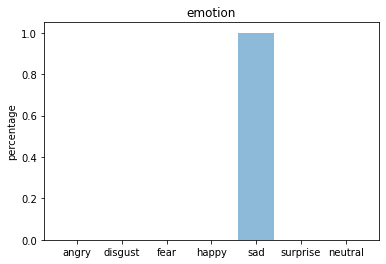

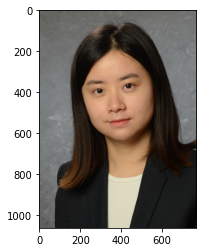

In [ ]:
result_show('/content/Di_Zhao.jpg')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


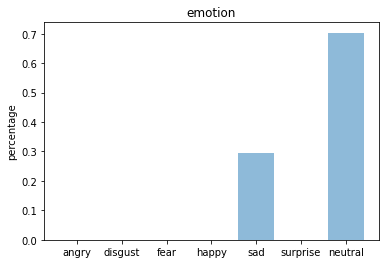

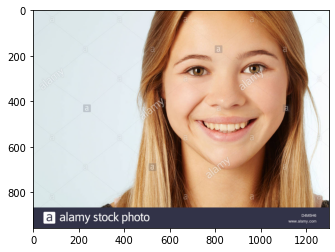

In [ ]:
result_show('/content/close-up-of-teenage-girls-smiling-face-D4M5H6.jpg')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


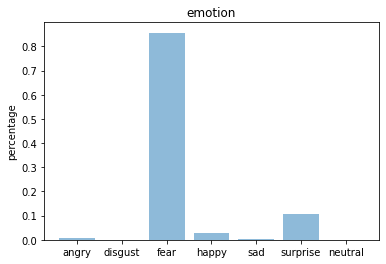

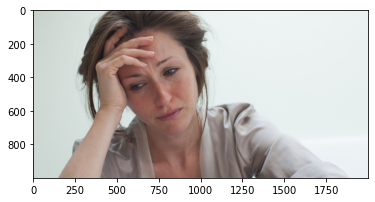

In [ ]:
result_show('/content/test2.jpg')

In [ ]:
import face_recognition
image = face_recognition.load_image_file("your_file.jpg")
face_locations = face_recognition.face_locations(image)